# 库和工具

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams["font.sans-serif"]=["SimHei"]
mpl.rcParams["axes.unicode_minus"]=False
from selenium import webdriver
from  time import sleep
import pandas as pd
import json
from  random import random
import re

# 导入数据

In [4]:
df=pd.read_excel('./websites.xlsx')
height,width = df.shape
print(height,width,type(df))
df.rename(columns={'疫情通报网址':'url'}, inplace=True)
df['url'] = df['url'].apply(lambda x: x.replace(' ',''))

193 1 <class 'pandas.core.frame.DataFrame'>


In [13]:
df

,url
0,https://mp.weixin.qq.com/s/HTsNM1zxEAx3IqoF1uYnYA
1,http://hc.nc.gov.cn/ncwjw/gzdt/202002/b5cf8972...
2,http://m.ha.bendibao.com/mip/1636.shtm
3,http://news.gxnews.com.cn/staticpages/20200209...
4,http://o.xiancity.cn/system/2020/02/09/0307133...
...,...
188,https://weibo.com/7129811001/ItKAzr93p?from=pa...
189,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...
190,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...
191,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...


# 预备

In [6]:
driver = webdriver.Chrome()
driver.get('https://weibo.com')

# 数据清洗

In [20]:
# 那些挂了的链接
import time
def clean_data(url_df,driver,use_driver=False):
    ''' 
        input:url_df,driver
    
        output:url_df_good,url_df_bad
    '''
    url_df_good = []
    url_df_bad = []
    s = time.time()
    for i in range(len(url_df)):
        u = url_df[i]
        print('[%d/%d]'%(i+1,len(url_df)),end='\r')
        try:
            r = reqs = requests.get(u,timeout=5)
        except requests.exceptions.ConnectionError as e:
            url_df_bad.append(u)
            continue
        if r.status_code != requests.codes.ok:
            url_df_bad.append(u)
            continue
        url_df_good.append(u)
    good = pd.DataFrame(url_df_good)
    bad = pd.DataFrame(url_df_bad)
    
    e = time.time()
    time_elsap = e-s
    print(time_elsap)
    
    return good,bad

good,bad = clean_data(df['url'],driver)

112.90089821815491


In [19]:
bad

,0
0,https://mp.weixin.qq.com/s/HTsNM1zxEAx3IqoF1uYnYA
1,http://hc.nc.gov.cn/ncwjw/gzdt/202002/b5cf8972...
2,http://m.ha.bendibao.com/mip/1636.shtm
3,http://news.gxnews.com.cn/staticpages/20200209...
4,http://o.xiancity.cn/system/2020/02/09/0307133...
...,...
181,https://mp.weixin.qq.com/s/zOGzJVviegMaLRE8tuiLRw
182,https://weibo.com/7129811001/IrH6peQ3d?from=pa...
183,https://weibo.com/7129811001/IssWHlJzw?from=pa...
184,https://weibo.com/7129811001/ItKAzr93p?from=pa...


# 数据获取

In [7]:
def get_data(url,driver,print_plot=False,print_textdict=False,use_driver=False):
    ''' 
        input:url,driver
    
        output:未处理前的html文本,经过html清洗之后的文本,每行文本的字典,每行文本长度的列表
    '''
    sleep(0.2)
    if 'weibo' in url:
        use_driver=True

    html =  ''
    if use_driver:
        # 用引擎
        driver.get(url)
        sleep(0.2)
        html =  driver.page_source
    else:
        # 用request
        try:
            r = reqs = requests.get(url,timeout=5)
        except requests.exceptions.ConnectionError as e:
            print("连接出错")
            return e,'','',''
        if r.status_code == requests.codes.ok:
            reqs.encoding = reqs.apparent_encoding
            html = reqs.text
        else:
            return r.status_code,'','',''
    # 去html的css和脚本
    soup = BeautifulSoup(html, features="html.parser")
    
#     if soup.title is not None:
#         title = soup.title.text
#     else:
#         title = 'unknow'
        
    for script in soup(["script", "style"]):
        script.decompose()
    text = soup.get_text()
    
    # 每行的字符数目统计
    count = []
    flag = 0
    k = 0
    row = 0
    s = []
    s_c = ''

    for si in text:
        if si != '\n':
            flag = 0 
            k+=1
            s_c += si
        else:
            flag = 1
            count.append(k)
            s.append(s_c)
            k=0
            s_c = ''
            row+=1
    
    if s_c != '':
        flag = 1
        count.append(k)
        s.append(s_c)
        k=0
        s_c = ''
        row+=1
    

    x = np.arange(1,len(count)+1,1)
    y = np.array(count)
    if print_plot:
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        #设置标题
        ax1.set_title('文本密度分布函数')
        plt.xlabel("字符行序号")
        plt.ylabel("字符数目")
        #画散点图
        ax1.scatter(x,y,c = 'r',marker = 'o')
        # 限制刻度
        my_x_ticks = np.arange(1, len(count)+1, 1)
        plt.xticks(my_x_ticks)   #设置坐标轴刻度
        #显示所画的图
        plt.show()
    if print_textdict:
        print (s)
    return html,text,s,y


In [8]:
df['url']

0      https://mp.weixin.qq.com/s/HTsNM1zxEAx3IqoF1uYnYA
1      http://hc.nc.gov.cn/ncwjw/gzdt/202002/b5cf8972...
2                 http://m.ha.bendibao.com/mip/1636.shtm
3      http://news.gxnews.com.cn/staticpages/20200209...
4      http://o.xiancity.cn/system/2020/02/09/0307133...
                             ...                        
188    https://weibo.com/7129811001/ItKAzr93p?from=pa...
189    https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...
190    https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...
191    https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...
192    https://mp.weixin.qq.com/s/URJDtNlB8jOnsmdH17VjXA
Name: url, Length: 193, dtype: object

In [9]:
# raw_html_data = []
# Chinese_text = []
# s_dict = []
# s_count = []
# for url in df['url']:
#     rawd,cT,s,y = get_data(url,driver)
#     raw_html_data.append(rawd)
#     Chinese_text.append(cT)
#     s_dict.append(s)
#     s_count.append(y)

'<!DOCTYPE html>\n<html class="\n\n">\n    <head>\n                        <meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="color-scheme" content="light dark">\n<meta name="viewport" content="width=device-width,initial-scale=1.0,maximum-scale=1.0,user-scalable=0,viewport-fit=cover">\n<link rel="shortcut icon" type="image/x-icon" href="//res.wx.qq.com/a/wx_fed/assets/res/NTI4MWU5.ico">\n<link rel="mask-icon" href="//res.wx.qq.com/a/wx_fed/assets/res/MjliNWVm.svg" color="#4C4C4C">\n<link rel="apple-touch-icon-precomposed" href="//res.wx.qq.com/a/wx_fed/assets/res/OTE0YTAw.png">\n<meta name="apple-mobile-web-app-capable" content="yes">\n<meta name="apple-mobile-web-app-status-bar-style" content="black">\n<meta name="format-detection" content="telephone=no">\n\n\n        \n\n  \n  <meta name="description" content="最新疫情通报" />\n  <meta name="author" content="" />\n\n  \n  <meta property="og:title" content=
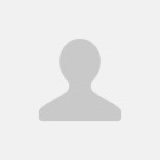
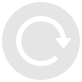
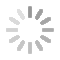
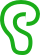
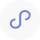
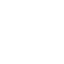
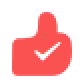
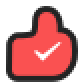
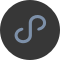

In [80]:
raw_html_data[0]

In [10]:
import sys,time
total = len(df['url'])
raw_html_data = []
Chinese_text = []
s_list = []
s_count = []

for i in range(len(df['url'])):
    rawd,cT,s,y = get_data(df['url'][i],driver)
    raw_html_data.append(rawd)
    Chinese_text.append(cT)
    s_list.append(s)
    s_count.append(y)
    if i+1 == total:
        percent = 100.0
        print('当前核算进度 : %s [%d/%d]'%(str(percent)+'%',i+1,total),end='\n')
    else:
        percent = round(1.0 * i / total * 100,2)
        print('当前核算进度 : %s [%d/%d]'%(str(percent)+'%',i+1,total),end='\r')


当前核算进度 : 100.0% [193/193]


In [21]:
Chinese_text[0]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                    \n                    \n                    \n截至2020年2月13日24时，肇庆市新冠肺炎疫情情况通报\n                \n\n\n\n                        健康肇庆                      \n\n\n健康肇庆\n\n\n微信号\nzhaoqingwjj\n\n\n功能介绍\n欢迎您！"健康肇庆"会不定期更新肇庆市卫生健康工作动态、健康教育、优生优育、健康常识和卫生健康政策法规等内容，是您了解肇庆市卫生健康局发展情况的移动信息平台，感谢您对肇庆卫生健康事业的支持！\n\n\n\n\n\n\n\n\n\n\n\n\n\n最新消息2月14日上午，省卫健委公布2月13日0－24时肇庆市新增1例新冠肺炎确诊病例。截至2月13日24时，肇庆市累计报告新冠肺炎确诊病例17例。13日0-24时全市新增确诊病例1例，分布在封开县。累计报告的17例确诊病例中，端州区5例，鼎湖区2例、高要区3例、四会市1例、广宁县1例、封开县5例。其中男性10例，女性7例，年龄介于3岁到65岁之间。截至2020年2月13日24时，在院的9例确诊病例中，普通型4例，轻型4例，重型1例。死亡1例。无医务人员感染。在院的9例病例，有1例病例病情加重，其余确诊病例病情稳定。全市共追踪到507名密切接触者，正接受集中医学观察277人，累计230人解除医学观察。17例确诊病例感染原因为湖北输入病例6例、旅游输入病例4例、由旅游输入引起的家庭病例3例、有武汉返肇人员接触史4例。目前，累计已有7例确诊病例治愈出院。\xa0肇庆市新增一例确诊病例情况如下：11病例17何某（女、65岁、封开人），现住封开县江口镇河堤二路22号。近期无湖北省居住、旅游史，感染原因是与新型冠状病毒感染肺炎病例有接触。1月19日下午3：00与何某、吴某（病例16、15）等人一起在封开县曲艺社排练。1月23日到何某（病例16）家中（水上居民安置楼），1月24日、1月

In [26]:
s_list[2]

['',
 '',
 '',
 '',
 '',
 '淮安经济技术开发区肺炎疫情+确诊人数（持续更新）- 淮安本地宝',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '淮安',
 '',
 '',
 '',
 '',
 '资讯 旅游 交通 指南 休闲 购物 美食 教育 人才 节日 二手房 租房 专题 网点 景点 公交 客车 地图天气推荐',
 '',
 '',
 '',
 '',
 '',
 '',
 '资讯 动态 正文',
 '',
 '淮安经济技术开发区肺炎疫情+确诊人数（持续更新）',
 '',
 '2020-02-12 15:12',
 '淮安网',
 '',
 '',
 '导语 截止到2020年2月11日，淮安经济技术开发区确诊病例共2例。以下是其详细情况：',
 '\r',
 '\t\u3000\u3000更新时间：2020年2月11日24时',
 '',
 '\r',
 '\t\u3000\u30001、男，49岁，现住淮安经济技术开发区大湖城邦小区，无湖北居住史和旅行史。1月20日在淮安区浅深浴室洗浴，下午与我市一名确诊患者有接触；1月27日自觉不适；1月29日晚出现发热、咳嗽症状；1月31日至2月3日驾车前往淮阴区一私人诊所输液治疗；2月4日下午驾车前往淮阴区营中社区卫生服务中心就诊，后转至淮安市淮阴医院，入院隔离观察治疗；2月5日转至淮安市第四人民医院；2月7日被确诊为新型冠状病毒感染的肺炎。\r',
 '',
 '\r',
 '\t\u3000\u30002、男，52岁，现住淮安经济技术开发区东方凯旋城小区，无湖北居住史和旅行史，与我市一确诊患者打过牌，系密切接触者。1月29日出现头痛、咳嗽、发热等症状，至淮安市第二人民医院就诊，口服药物治疗；1月30日自觉症状未缓解，至淮安市第一人民医院就诊，1月31日晚接受输液治疗，至2月1日凌晨回家，在家休息一天；2月2日上午再次发烧，至清江浦区钵池山社区卫生服务中心就诊，服药治疗；2月3日至5日在淮安市第一人民医院输液治疗，2月7日入院隔离观察治疗，当晚转至淮安市第四人民医院；

'<!DOCTYPE html>\n<html class="\n\n">\n    <head>\n                        <meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="color-scheme" content="light dark">\n<meta name="viewport" content="width=device-width,initial-scale=1.0,maximum-scale=1.0,user-scalable=0,viewport-fit=cover">\n<link rel="shortcut icon" type="image/x-icon" href="//res.wx.qq.com/a/wx_fed/assets/res/NTI4MWU5.ico">\n<link rel="mask-icon" href="//res.wx.qq.com/a/wx_fed/assets/res/MjliNWVm.svg" color="#4C4C4C">\n<link rel="apple-touch-icon-precomposed" href="//res.wx.qq.com/a/wx_fed/assets/res/OTE0YTAw.png">\n<meta name="apple-mobile-web-app-capable" content="yes">\n<meta name="apple-mobile-web-app-status-bar-style" content="black">\n<meta name="format-detection" content="telephone=no">\n\n\n        \n\n  \n  <meta name="description" content="最新疫情通报" />\n  <meta name="author" content="" />\n\n  \n  <meta property="og:title" content=
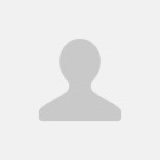
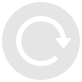
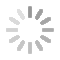
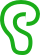
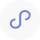
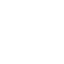
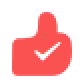
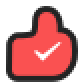
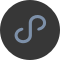

In [38]:
raw_html_data[0]

In [39]:
s_list_arr = np.array(s_list)
s_count_arr = np.array(s_count)
raw_arr = np.array(raw_html_data)
text_arr = np.array(Chinese_text)

In [40]:
s_count_arr

array([array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   20,   20,   20,   29,   16,    0,    0,    0,
         50,    0,    0,    4,    0,    0,    3,   11,    0,    0,    4,
         95,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 4493,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   13,    0,    0,    0,    0,   20,    0,    0,    0,    0,
          5,    0,    0,    0,    0,    0,    0,    0,    8,    0,   41,
          0,    4,    0,    0,    0,    0,  

In [41]:
df['raw'] = pd.DataFrame(raw_arr)
df['text'] =  pd.DataFrame(text_arr)
df['s_list'] = pd.DataFrame(s_list_arr)
df['scount'] = pd.DataFrame(s_count_arr)

In [42]:
df

,url,raw,text,s_list,scount
0,https://mp.weixin.qq.com/s/HTsNM1zxEAx3IqoF1uYnYA,"<!DOCTYPE html>\n<html class=""\n\n"">\n <hea...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,http://hc.nc.gov.cn/ncwjw/gzdt/202002/b5cf8972...,"<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head>\...",\n\n\n\n南昌市卫生健康委员会\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[, , , , 南昌市卫生健康委员会, , , , , , , , , , , , , ,...","[0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,http://m.ha.bendibao.com/mip/1636.shtm,<!DOCTYPE html>\r\n<html mip>\r\n<head>\r\n\t<...,\n\n\n\n\n淮安经济技术开发区肺炎疫情+确诊人数（持续更新）- 淮安本地宝\n\n\...,"[, , , , , 淮安经济技术开发区肺炎疫情+确诊人数（持续更新）- 淮安本地宝, , ...","[0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,http://news.gxnews.com.cn/staticpages/20200209...,<!DOCTYPE html>\n<html>\n<head>\n<meta charset...,\n\n\n\n\n2月8日广西新增确诊病例12例 新增死亡病例1例-广西新闻网\n\n\n...,"[, , , , , 2月8日广西新增确诊病例12例 新增死亡病例1例-广西新闻网, , ,...","[0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,http://o.xiancity.cn/system/2020/02/09/0307133...,"<html><head>\r\n\n <meta http-equiv=""Conten...",\n\n\n\n\n\n周至县疫情防控指挥部今日发布寻人通告-原创频道-西安网\n\n\n\...,"[, , , , , , 周至县疫情防控指挥部今日发布寻人通告-原创频道-西安网, , , ...","[0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
188,https://weibo.com/7129811001/ItKAzr93p?from=pa...,"<html><head>\n<meta charset=""utf-8"">\n<meta co...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
189,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...,403,,,
190,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...,403,,,
191,https://www.sg.gov.cn/xw/ztjj/yqfkyz/zxyq/cont...,403,,,


# 保存数据

In [43]:
df.to_csv('./text_4.27.csv')